In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pandas as pd
import json
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from io import StringIO  

In [25]:
df = pd.concat([pd.read_csv(fn) for fn in csv_list if os.path.exists(fn)])
df

,subject,session,side,label,VoronoiRadius_mean,VoronoiRadius_median,VoronoiRadius_q95
0,023_S_0031,2018-04-17,right,15,0.869610,0.845128,1.494353
1,023_S_0031,2018-04-17,right,8,0.730175,0.712379,0.992799
2,023_S_0031,2018-04-17,right,10,0.918246,0.844735,1.537066
3,023_S_0031,2018-04-17,right,11,1.147077,1.123928,1.802492
4,023_S_0031,2018-04-17,right,12,1.435370,1.432205,2.164193
...,...,...,...,...,...,...,...
1,082_S_7122,2023-04-04,left,8,0.820540,0.833575,1.049659
2,082_S_7122,2023-04-04,left,10,0.972094,0.955706,1.316802
3,082_S_7122,2023-04-04,left,11,1.212666,1.196717,1.660036
4,082_S_7122,2023-04-04,left,12,1.217055,1.253345,1.741311


In [26]:
# Only focus on one thickness value 
df_med=df.rename(columns={'VoronoiRadius_median': 'thk'}).loc[:,['subject','session','side','label','thk']]
df_med.label=df_med.label.replace({8:'SUB_thk',10:'ERC_thk',11:'BA35_thk',12:'BA36_thk',13:'PHC_thk',15:'WM_thk'})
df_med.session=pd.to_datetime(df_med.session)
df_med

,subject,session,side,label,thk
0,023_S_0031,2018-04-17,right,WM_thk,0.845128
1,023_S_0031,2018-04-17,right,SUB_thk,0.712379
2,023_S_0031,2018-04-17,right,ERC_thk,0.844735
3,023_S_0031,2018-04-17,right,BA35_thk,1.123928
4,023_S_0031,2018-04-17,right,BA36_thk,1.432205
...,...,...,...,...,...
1,082_S_7122,2023-04-04,left,SUB_thk,0.833575
2,082_S_7122,2023-04-04,left,ERC_thk,0.955706
3,082_S_7122,2023-04-04,left,BA35_thk,1.196717
4,082_S_7122,2023-04-04,left,BA36_thk,1.253345


In [27]:
# Pivot by label but not yet by side
df_wide = df_med.pivot(index=['subject','session','side'], columns='label', values='thk').reset_index()
df_wide.head()

label,subject,session,side,BA35_thk,BA36_thk,ERC_thk,PHC_thk,SUB_thk,WM_thk
0,002_S_0413,2017-06-21,left,1.274518,1.309992,1.061954,1.112808,0.809841,0.904224
1,002_S_0413,2017-06-21,right,1.504863,1.169367,1.105987,1.110820,0.816431,0.790008
2,002_S_0413,2019-08-27,left,1.359686,1.343466,1.057175,1.085489,0.799650,0.925318
3,002_S_0413,2019-08-27,right,1.575307,1.187600,1.130163,1.198151,0.800807,0.845926
4,002_S_1155,2017-04-24,left,1.061843,1.326814,1.067174,1.094006,0.875019,0.982467


In [28]:
# Also read all the jsons and extract the qc ratings
qc_list = []
for i, row in df_wide.iterrows():
    sub, sess, side = row['subject'], row['session'].strftime('%Y-%m-%d'), row['side']
    fullid=f'{sub}_{sess}_{side}'
    with open(f'../work/adnit2/{sub}/{sess}/{fullid}/final/{fullid}_fitted_dist_stat.json', 'rt') as fd:
        d = json.load(fd)
        qc_list.append(d['q95'])
    
df_wide['crashs_qc95'] = qc_list
df_wide

label,subject,session,side,BA35_thk,BA36_thk,ERC_thk,PHC_thk,SUB_thk,WM_thk,crashs_qc95
0,002_S_0413,2017-06-21,left,1.274518,1.309992,1.061954,1.112808,0.809841,0.904224,0.599613
1,002_S_0413,2017-06-21,right,1.504863,1.169367,1.105987,1.110820,0.816431,0.790008,0.617437
2,002_S_0413,2019-08-27,left,1.359686,1.343466,1.057175,1.085489,0.799650,0.925318,0.599215
3,002_S_0413,2019-08-27,right,1.575307,1.187600,1.130163,1.198151,0.800807,0.845926,0.601227
4,002_S_1155,2017-04-24,left,1.061843,1.326814,1.067174,1.094006,0.875019,0.982467,0.759092
...,...,...,...,...,...,...,...,...,...,...
3741,941_S_7085,2022-07-01,right,1.217667,1.363349,1.112102,1.145968,0.770386,0.849664,0.536085
3742,941_S_7087,2022-06-15,left,1.384645,1.361326,0.987816,1.237389,0.904400,1.091296,0.616117
3743,941_S_7087,2022-06-15,right,1.381042,1.365727,0.988253,1.370413,0.824882,0.986463,0.654672
3744,941_S_7106,2022-09-09,left,1.287281,1.384053,0.982131,1.328662,0.852792,1.044425,0.635765


In [29]:
# Now additionally pivot on side
df_bilat = df_wide.pivot(index=['subject','session'], columns='side').reset_index()
df_bilat.columns = df_bilat.columns.map(lambda x : '_'.join(reversed(x)) if len(x[1]) > 1 else x[0])
df_bilat.head()

,subject,session,left_BA35_thk,right_BA35_thk,left_BA36_thk,right_BA36_thk,left_ERC_thk,right_ERC_thk,left_PHC_thk,right_PHC_thk,left_SUB_thk,right_SUB_thk,left_WM_thk,right_WM_thk,left_crashs_qc95,right_crashs_qc95
0,002_S_0413,2017-06-21,1.274518,1.504863,1.309992,1.169367,1.061954,1.105987,1.112808,1.110820,0.809841,0.816431,0.904224,0.790008,0.599613,0.617437
1,002_S_0413,2019-08-27,1.359686,1.575307,1.343466,1.187600,1.057175,1.130163,1.085489,1.198151,0.799650,0.800807,0.925318,0.845926,0.599215,0.601227
2,002_S_1155,2017-04-24,1.061843,1.290850,1.326814,1.342214,1.067174,1.033065,1.094006,1.149612,0.875019,0.902599,0.982467,0.837198,0.759092,0.582105
3,002_S_1155,2018-05-08,1.066504,1.237815,1.321788,1.372084,1.083241,1.103903,1.080249,1.166052,0.832565,0.838241,0.894291,0.941793,0.669160,0.592010
4,002_S_1155,2019-05-16,1.072108,1.269968,1.278992,1.309044,1.161383,1.122809,1.127755,1.196266,0.820352,0.833995,0.950691,0.905649,0.669131,0.574033


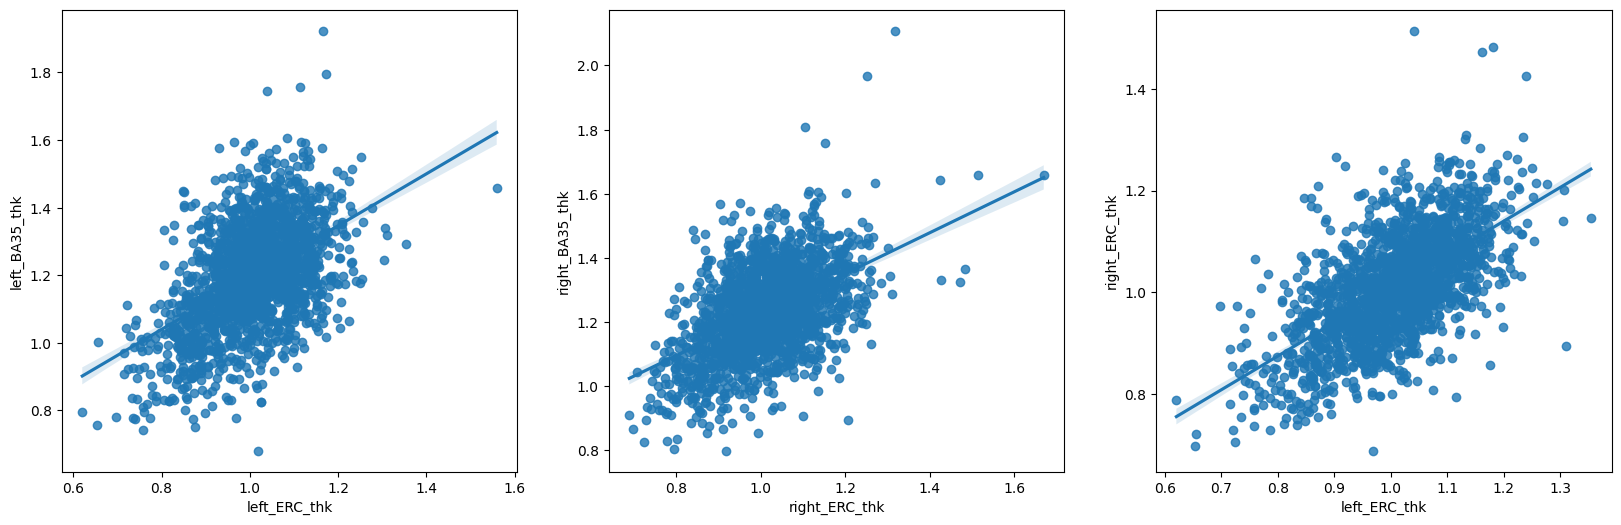

In [30]:
fig,ax = plt.subplots(1,3,figsize=(20,6));
sns.regplot(data=df_bilat, x='left_ERC_thk', y='left_BA35_thk', ax=ax[0]);
sns.regplot(data=df_bilat, x='right_ERC_thk', y='right_BA35_thk', ax=ax[1]);
sns.regplot(data=df_bilat, x='left_ERC_thk', y='right_ERC_thk', ax=ax[2]);

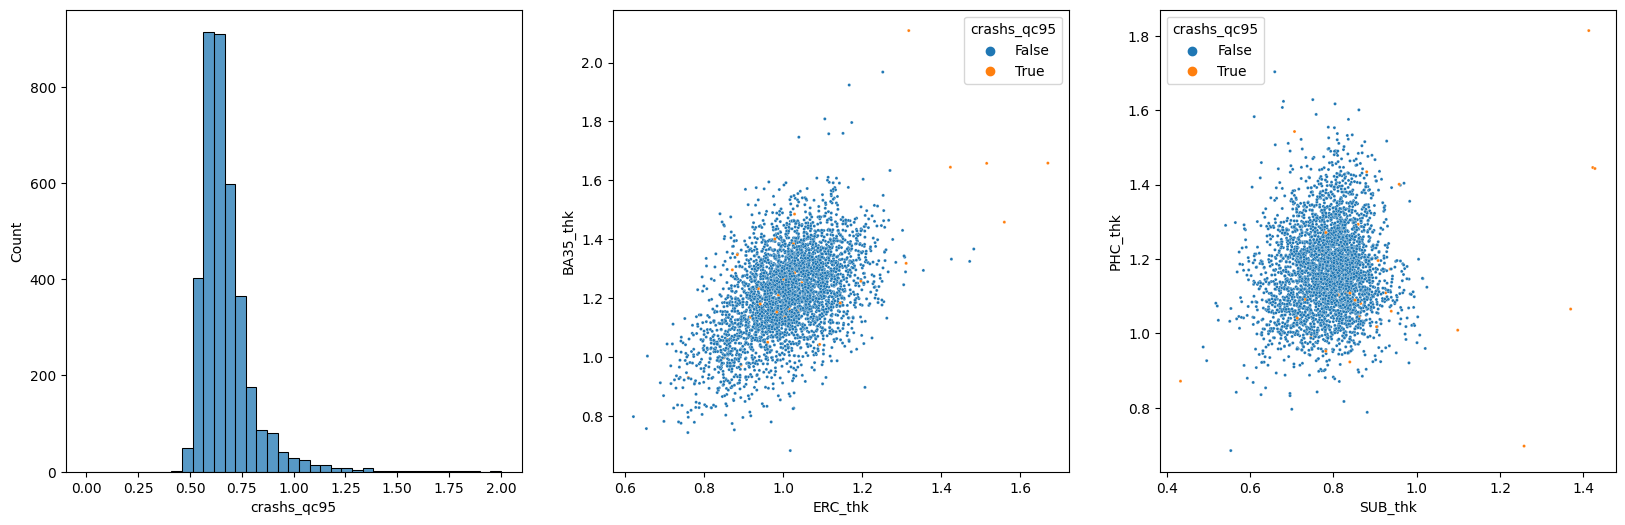

In [31]:
# Plot QC score distribution
fig,ax = plt.subplots(1,3,figsize=(20,6));
sns.histplot(data=df_wide, x='crashs_qc95', ax=ax[0], bins=np.linspace(0, 2, 40))
sns.scatterplot(data=df_wide, x='ERC_thk', y='BA35_thk', hue=df_wide.crashs_qc95 > 1.25, ax=ax[1], s=5);
sns.scatterplot(data=df_wide, x='SUB_thk', y='PHC_thk', hue=df_wide.crashs_qc95 > 1.25, ax=ax[2], s=5);

In [33]:
# Print some bad scores to examine
df_wide.sort_values('crashs_qc95').tail(20)

label,subject,session,side,BA35_thk,BA36_thk,ERC_thk,PHC_thk,SUB_thk,WM_thk,crashs_qc95
3140,137_S_6654,2018-12-31,right,1.152261,1.358959,0.983003,1.089540,0.852178,0.990897,1.368142
2121,098_S_6747,2019-07-10,left,1.134148,1.342895,0.916854,1.108091,0.830008,0.916417,1.370158
1032,027_S_6002,2017-01-23,right,1.256688,1.348096,1.196143,1.277778,0.778312,0.765958,1.406412
1720,041_S_6785,2020-10-28,left,1.263449,1.262147,1.000310,1.400751,0.957948,0.999894,1.443066
1859,067_S_6474,2018-06-27,right,1.285391,1.383624,1.028324,1.293126,0.859441,0.986999,1.477581
3033,135_S_6446,2019-07-11,left,1.485046,1.468287,1.028174,0.990968,0.746023,0.883530,1.494421
1322,035_S_6306,2018-04-18,left,1.512883,1.404814,1.035867,1.275769,0.824296,1.026305,1.515330
3666,941_S_6454,2018-06-27,left,1.400752,1.542646,0.978250,1.271118,0.781910,1.150454,1.584819
1116,029_S_6289,2018-03-30,right,1.119586,1.254870,1.007294,1.223894,0.774656,0.861973,1.605543
367,011_S_6367,2018-05-16,left,1.244475,1.348110,0.960964,1.224842,0.830644,0.993424,1.636821


In [76]:
# Export the data in format we can use for main ADNI analysis
df_bilat.rename(columns={'subject':'ID','session':'SMARTDATE'}).to_csv('work/adni_crashs_thickness.csv')

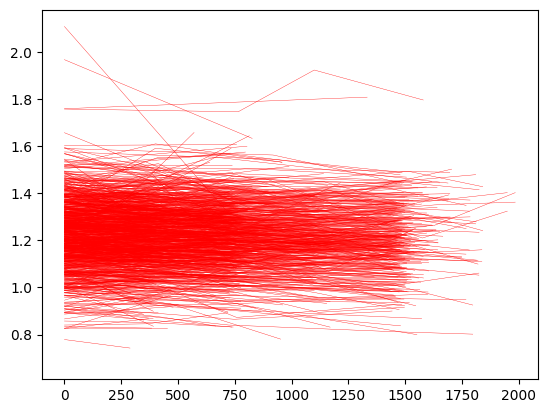

In [35]:
k = 0
for _,q in df_wide.groupby(['subject','side']):
    plt.plot((q.session - q.session.min()) / np.timedelta64(1, 'D'), q.BA35_thk, linewidth=0.25, color='red')

In [64]:
x = df_wide.groupby(['subject','side']).agg({'session':'min'}).reset_index()
x = df_wide.merge(x, on=['subject','side'])
y = x.groupby(['subject','side']).size().reset_index(name='obs')
x = x.merge(y.loc[y.obs > 1, :], how='inner')
x['time'] = (x.session_x - x.session_y) / np.timedelta64(1, 'Y')
x

,subject,session_x,side,BA35_thk,BA36_thk,ERC_thk,PHC_thk,SUB_thk,WM_thk,crashs_qc95,session_y,obs,time
0,002_S_0413,2017-06-21,left,1.274518,1.309992,1.061954,1.112808,0.809841,0.904224,0.599613,2017-06-21,2,0.000000
1,002_S_0413,2019-08-27,left,1.359686,1.343466,1.057175,1.085489,0.799650,0.925318,0.599215,2017-06-21,2,2.182112
2,002_S_0413,2017-06-21,right,1.504863,1.169367,1.105987,1.110820,0.816431,0.790008,0.617437,2017-06-21,2,0.000000
3,002_S_0413,2019-08-27,right,1.575307,1.187600,1.130163,1.198151,0.800807,0.845926,0.601227,2017-06-21,2,2.182112
4,002_S_1155,2017-04-24,left,1.061843,1.326814,1.067174,1.094006,0.875019,0.982467,0.759092,2017-04-24,3,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2684,941_S_6854,2021-04-05,left,1.119182,1.466650,0.868711,1.158307,0.744245,0.858900,0.616457,2020-02-14,3,1.138969
2685,941_S_6854,2022-02-22,left,1.064365,1.471895,0.923230,1.147395,0.733317,0.810436,0.577267,2020-02-14,3,2.023313
2686,941_S_6854,2020-02-14,right,1.110552,1.349140,0.926517,1.058091,0.644971,0.821948,0.552715,2020-02-14,3,0.000000
2687,941_S_6854,2021-04-05,right,1.062991,1.419360,0.899863,1.038603,0.630833,0.832986,0.578952,2020-02-14,3,1.138969


In [75]:
xl = x.query('side == "left"')
m = smf.mixedlm("SUB_thk ~ time", xl, groups=xl['subject'])
m.fit().summary()


/home/pauly2/.conda/envs/deformetrica/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: SUB_thk  
No. Observations: 1342    Method:             REML     
No. Groups:       494     Scale:              0.0006   
Min. group size:  2       Log-Likelihood:     2266.4445
Max. group size:  6       Converged:          Yes      
Mean group size:  2.7                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    0.807    0.003 242.058 0.000  0.800  0.814
time        -0.005    0.001  -9.611 0.000 -0.006 -0.004
Group Var    0.005    0.017                            
=======================================================

"""